In [3]:
import torch as t
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from einops import rearrange
from tqdm.notebook import tqdm_notebook

from my_transformer import TransformerConfig, DecoderOnlyTransformer

In [4]:
class CustomTextDataset(Dataset):
    def __init__(self, vocab_size: int, seq_len: int, datasize: int):
        self.datasize = datasize
        self.vocab_size = vocab_size
        self.seq_len = seq_len

    def __len__(self):
            return self.datasize

    def __getitem__(self, idx):
            input = t.randint(0, self.vocab_size, (self.seq_len,))
            target = t.flip(input, dims=(0,))
            return (input, target)

In [5]:
config = TransformerConfig(
    num_layers=2,
    num_heads=4,
    vocab_size=10,
    hidden_size=96,
    max_seq_len=6,
    dropout=0.1,
    layer_norm_epsilon=1e-05
)

trainset = CustomTextDataset(
    vocab_size=config.vocab_size,
    seq_len=config.max_seq_len,
    datasize=10000
)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


In [6]:
model = DecoderOnlyTransformer(config)
optimizer = t.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []

In [10]:
# Test the model on the first few datapoints
model.eval()
for i in range(10):
    with t.no_grad():
        input, target = trainset[i]
        output = model(input.unsqueeze(0)).argmax(dim=-1)
        print(input, output, target)

tensor([7, 4, 6, 5, 8, 0]) tensor([[7, 4, 6, 5, 8, 0]]) tensor([0, 8, 5, 6, 4, 7])
tensor([8, 0, 1, 6, 9, 6]) tensor([[8, 0, 1, 6, 9, 6]]) tensor([6, 9, 6, 1, 0, 8])
tensor([0, 9, 3, 7, 9, 3]) tensor([[0, 9, 3, 7, 9, 3]]) tensor([3, 9, 7, 3, 9, 0])
tensor([2, 3, 8, 2, 3, 4]) tensor([[2, 3, 8, 2, 3, 4]]) tensor([4, 3, 2, 8, 3, 2])
tensor([7, 2, 2, 4, 5, 4]) tensor([[7, 2, 2, 4, 5, 4]]) tensor([4, 5, 4, 2, 2, 7])
tensor([2, 6, 3, 0, 2, 6]) tensor([[2, 6, 3, 0, 2, 6]]) tensor([6, 2, 0, 3, 6, 2])
tensor([6, 0, 4, 4, 7, 3]) tensor([[6, 0, 4, 4, 7, 3]]) tensor([3, 7, 4, 4, 0, 6])
tensor([9, 2, 6, 6, 8, 1]) tensor([[9, 2, 6, 6, 8, 1]]) tensor([1, 8, 6, 6, 2, 9])
tensor([9, 7, 6, 4, 4, 5]) tensor([[9, 7, 6, 4, 4, 5]]) tensor([5, 4, 4, 6, 7, 9])
tensor([3, 5, 5, 1, 8, 0]) tensor([[3, 5, 5, 1, 8, 0]]) tensor([0, 8, 1, 5, 5, 3])


In [11]:
NUM_EPOCHS = 5

model.train()
for epoch in tqdm_notebook(range(1, NUM_EPOCHS + 1)):
    for inputs, targets in tqdm_notebook(trainloader, leave=False):
        
        outputs = model(inputs)
        
        loss = criterion(
            rearrange(outputs, 'batch seq vocab -> (batch seq) vocab'),
            rearrange(targets, 'batch seq -> (batch seq)'),
        )
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

<AxesSubplot:>

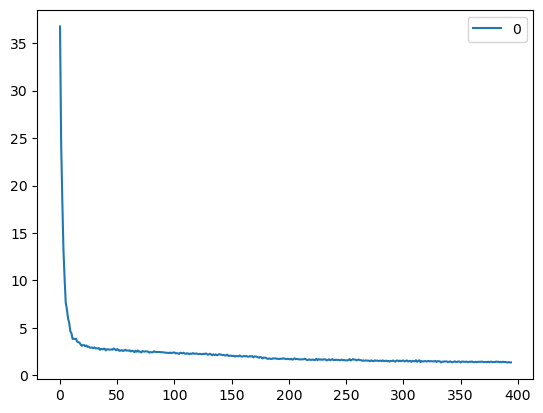

In [12]:
df = pd.DataFrame(train_losses)
df.plot()

In [13]:
# Test the model again on the first few datapoints
model.eval()
for i in range(10):
    with t.no_grad():
        input, target = trainset[i]
        output = model(input.unsqueeze(0)).argmax(dim=-1)
        print(input, output, target)

tensor([7, 6, 3, 3, 7, 5]) tensor([[0, 1, 0, 3, 6, 7]]) tensor([5, 7, 3, 3, 6, 7])
tensor([7, 3, 0, 1, 0, 3]) tensor([[0, 1, 1, 0, 3, 7]]) tensor([3, 0, 1, 0, 3, 7])
tensor([1, 3, 3, 5, 7, 4]) tensor([[5, 1, 0, 3, 3, 1]]) tensor([4, 7, 5, 3, 3, 1])
tensor([8, 7, 7, 0, 2, 0]) tensor([[5, 0, 0, 7, 7, 8]]) tensor([0, 2, 0, 7, 7, 8])
tensor([8, 1, 3, 8, 2, 7]) tensor([[5, 0, 0, 3, 1, 8]]) tensor([7, 2, 8, 3, 1, 8])
tensor([5, 1, 8, 2, 1, 9]) tensor([[1, 0, 0, 8, 1, 5]]) tensor([9, 1, 2, 8, 1, 5])
tensor([8, 1, 0, 2, 8, 9]) tensor([[5, 0, 1, 0, 1, 8]]) tensor([9, 8, 2, 0, 1, 8])
tensor([3, 6, 3, 4, 1, 0]) tensor([[1, 0, 0, 3, 6, 3]]) tensor([0, 1, 4, 3, 6, 3])
tensor([5, 1, 0, 5, 4, 3]) tensor([[1, 0, 1, 0, 1, 5]]) tensor([3, 4, 5, 0, 1, 5])
tensor([5, 0, 5, 9, 7, 8]) tensor([[1, 1, 0, 5, 0, 5]]) tensor([8, 7, 9, 5, 0, 5])
